# Project6 ChIP_Seq scale region signal calculation

By CAO Gaoxiang

2023-6-5

## steps
1. 读取BED文件，获得TSS；
2. 根据TSS，获得子区间；
3. 读取BAM文件，计算每个子区间的信号强度（基于项目4）；
4. 输出计算结果；
5. 读取结果，进行排序，画图。

In [1]:
import pysam

In [2]:
def multi_query_region_signal(
    signal_bam_obj,
    query_region_list,
    scale_method):
    """
    INPUT: 
        <signal_bam_obj>
            pysam AlignmentFile obj
            
        <query_region_list>
            list, each item contains three info, chrom, start, end 
            
        <scale_method>
            str, cpm, rpkm, raw
    RETURN:
        <signal_value_list>
            list, same length as input <query_region_list>
    """
    # count total
    total_count = 0

    for info in signal_bam_obj.get_index_statistics():
        total_count += info.mapped
    
    # query value
    signal_value_list = []
    
    for region_info in query_region_list:
        region_chr_name = region_info[0]
        region_start = int(region_info[1])
        region_end = int(region_info[2])

        region_count = 0
        
        for align in signal_bam_obj.fetch(contig=region_chr_name, start=region_start, end=region_end):
            region_count += 1
            
        if scale_method == "cpm":
            scale_value = region_count / 1.0 / (total_count / 1e6)
        elif scale_method == "rpkm":
            region_length = region_end - region_start
            scale_value = region_count / 1.0 / (total_count / 1e6) / (region_length / 1e3)
        elif scale_method == "raw":
            scale_value = region_count
        
        signal_value_list.append(round(scale_value, 6))
        
    return signal_value_list

In [3]:
# multi_query_region_signal(bam_file_obj, query_region_list, scale_method="cpm")

In [3]:
in_bed_file = open("./hg38_refseq_gene_TSS_TES_protein_only.chr21.bed", "rt")
bam_file_obj = pysam.AlignmentFile("./bam_files/K562-ATACSeq-rep1.ENCFF534DCE_chr21_chr22.bam", "r")


extend_length = 3000
extend_binsize =100

all_info_list = []


for region in in_bed_file:
    region_list = region.strip().split("\t")
    # print(region_list)
    
    if region_list[5] == "+":
        ref_site = int(region_list[1])
    else:
        ref_site = int(region_list[2])
    
    chr_name = region_list[0]
    
    # make sub region
    upstream_region_list = []
    query_region_list = []
    downstream_region_list = []
    
    # ref site region 
    ref_site_start = ref_site - int(extend_binsize / 2)
    ref_site_end = ref_site + int(extend_binsize / 2)
       
    # upstream
    for up_region_start in range(ref_site_start - extend_length, ref_site_start, extend_binsize):
        up_region_end = min(ref_site_end + extend_binsize, ref_site_start)
        
        upstream_region_list.append(
            [chr_name, up_region_start, up_region_end]
        )
   
    # downstream
    for down_region_start in range(ref_site_end, ref_site_end + extend_length, extend_binsize):
        down_region_end = min(down_region_start + extend_binsize, ref_site_end + extend_length)
        
        downstream_region_list.append(
            [chr_name, down_region_start, down_region_end]
        )
    
    # query region 

    query_region_list.append(
    [chr_name, ref_site_start, ref_site_end]
    )

    # get signal value 
    up_signal_val_list = multi_query_region_signal(
        signal_bam_obj=bam_file_obj, 
        query_region_list=upstream_region_list, 
        scale_method="rpkm"
    )
    
    query_signal_val_list = multi_query_region_signal(
    signal_bam_obj=bam_file_obj, 
    query_region_list=query_region_list, 
    scale_method="rpkm"
    )
    
    down_signal_val_list = multi_query_region_signal(
    signal_bam_obj=bam_file_obj, 
    query_region_list=downstream_region_list, 
    scale_method="rpkm"
    )
    
    # merge signal
    if region_list[5] == "+":
        merge_val_list = up_signal_val_list + query_signal_val_list + down_signal_val_list
    
    elif region_list[5] =="-":
        merge_val_list = down_signal_val_list[::-1] + query_signal_val_list + up_signal_val_list[::-1]
        
    all_info_list.append(
        region_list + merge_val_list
    )


[W::hts_idx_load3] The index file is older than the data file: ./bam_files/K562-ATACSeq-rep1.ENCFF534DCE_chr21_chr22.bam.bai


In [10]:
len(all_info_list[0])

67

In [4]:
# sort signal 
all_info_list_sort = sorted(all_info_list, key=lambda x: sum(x[6:]) / (len(x) - 6), reverse=True)

# signal_out_file = open("./signal_H3K4me3.ScaleRegion.csv", "wt")
signal_out_file = open("./signal_ATACSeq.RefPoint.csv", "wt")

# output header
header_list = ["chrom", "tss", "tes", "gene_id", "exon_num", "strand"]

value_header_list = [
    f"col{i}" for i in range(1, len(all_info_list_sort[0]) - 6 + 1)
]

out_header_list = header_list + value_header_list
out_header_str = ",".join(out_header_list)
signal_out_file.write(out_header_str + "\n")

# output value 
for signal_info in all_info_list_sort:
    out_str = ",".join(map(str, signal_info))
    signal_out_file.write(out_str + "\n")
    
signal_out_file.close()

In [5]:
import seaborn as sns
import pandas as pd 
import numpy as np 

In [8]:
# df = pd.read_csv("./signal_H3K4me3.ScaleRegion.csv")
df = pd.read_csv("./signal_ATACSeq.RefPoint.csv")
df

,chrom,tss,tes,gene_id,exon_num,strand,col1,col2,col3,col4,...,col52,col53,col54,col55,col56,col57,col58,col59,col60,col61
0,chr21,33543037,33577481,SON,11,+,356.602731,368.580432,381.331100,394.212657,...,179.207035,76.307512,31.216709,32.372884,48.559326,86.713082,117.929791,92.493954,41.622279,20.811140
1,chr21,33503930,33542892,GART,22,-,52.027849,106.368047,108.680396,73.995163,...,366.011789,351.161704,337.150515,323.969708,311.704624,301.628119,291.013384,280.826509,271.700989,263.453612
2,chr21,46324155,46445769,PCNT,47,+,254.358373,259.262147,264.268439,269.174534,...,186.144082,105.211872,121.398314,89.025431,32.372884,32.372884,26.592012,16.186442,11.561744,9.249395
3,chr21,33449140,33479974,TMEM50B,7,-,41.622279,35.841407,36.997582,35.841407,...,268.617857,256.880935,246.214884,236.437669,227.396385,219.317394,211.922489,204.849332,198.582924,192.233267
4,chr21,37223419,37268108,VPS26C,7,-,17.342616,24.279663,31.216709,80.932210,...,502.990930,480.916006,461.062252,442.044021,424.824730,409.641491,395.240367,381.537559,368.899377,358.028679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,chr21,17917339,18267370,CHODL,5,+,4.778854,4.465225,4.542114,4.496234,...,3.468523,1.156174,1.156174,1.156174,0.000000,0.000000,0.000000,2.312349,4.624698,2.312349
222,chr21,43565181,43565648,H2BC12L,1,+,3.083132,3.069842,3.055604,3.168774,...,0.000000,0.000000,0.000000,0.000000,4.624698,10.405570,8.093221,9.249395,8.093221,2.312349
223,chr21,30616424,30616699,KRTAP20-1,1,+,3.699758,3.787468,3.798859,3.939557,...,1.156174,2.312349,5.780872,2.312349,3.468523,6.937047,5.780872,6.937047,6.937047,10.405570
224,chr21,18269115,18403785,TMPRSS15,25,-,2.312349,1.156174,1.156174,2.312349,...,2.257293,2.207242,2.111275,2.119653,2.081114,2.045539,2.012600,1.940721,1.953536,1.926957


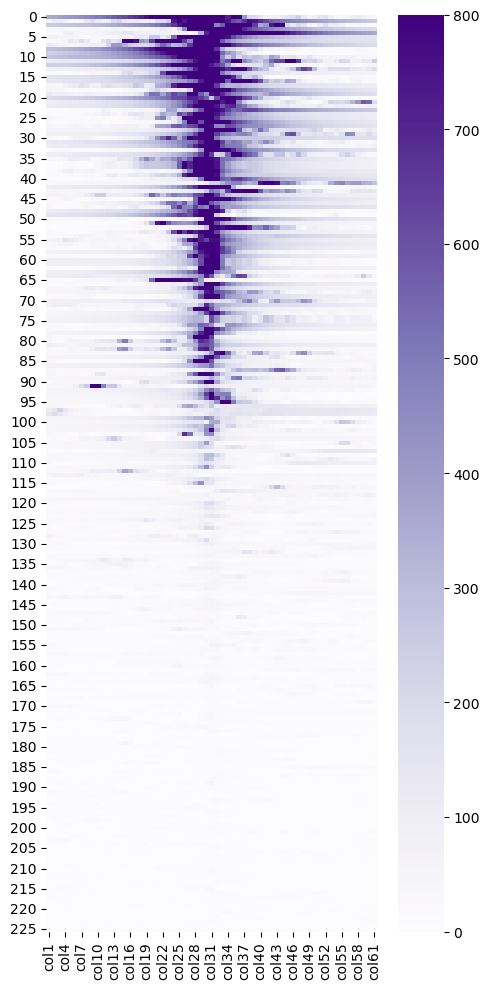

In [33]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [5, 10]
plt.rcParams["figure.autolayout"] = True

# cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
# p1 = sns.heatmap(df.iloc[:, 6:67], vmin=0, vmax=1000, cmap="Purples")
p1 = sns.heatmap(df.iloc[:, 6:67], vmin=0, vmax=800, cmap="Purples")
fig_p1 = p1.get_figure()
# fig_p1.savefig("./H3K4me3_heatmap.pdf", dpi=300)
fig_p1.savefig("./ATACSeq_TSS_heatmap.pdf", dpi=300)

In [24]:
a = df.iloc[:, 6:67].sum(0) / 61

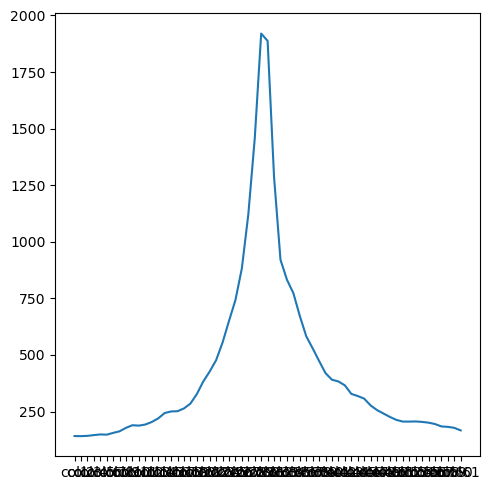

In [25]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

p2 = sns.lineplot(a)
fig_p2 = p2.get_figure()
fig_p2.savefig("./ATACSeq_TSS_profile.pdf", dpi=300)

In [34]:
import seaborn as sns
import pandas as pd 
import numpy as np 

In [35]:
df = pd.read_csv("/mnt/c/Users/caogaoxiang/Desktop/test.csv")
df

,chrom,tss,tes,gene_id,exon_num,strand,col1,col2,col3,col4,...,col152,col153,col154,col155,col156,col157,col158,col159,col160,col161
0,chr21,33543037,33577481,SON,11,+,227.650744,229.740033,232.013533,234.310070,...,108.680396,122.554489,154.927373,189.612605,161.864419,138.740931,83.244558,48.559326,30.060535,34.685233
1,chr21,46324155,46445769,PCNT,47,+,202.376771,203.743626,204.949613,206.418852,...,43.934628,48.559326,46.246977,39.309930,36.997582,18.498791,23.123488,16.186442,18.498791,13.874093
2,chr21,39174768,39183451,PSMG1,7,-,198.862001,258.983071,245.108978,242.796629,...,186.892195,186.233018,185.555087,184.516874,181.708576,179.537371,176.549863,174.064053,171.388161,169.186857
3,chr21,33503930,33542892,GART,22,-,36.997582,36.997582,43.934628,55.496372,...,322.958055,317.192006,312.167094,306.557507,301.278033,295.980652,291.031414,286.133235,281.753828,277.558940
4,chr21,33449140,33479974,TMEM50B,7,-,43.934628,55.496372,57.808721,55.496372,...,243.340711,238.838955,234.943368,230.977957,226.904486,223.059080,219.470303,216.244485,212.736094,209.421727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,chr21,17917339,18267370,CHODL,5,+,4.902180,4.881625,4.860652,4.791568,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.312349,4.624698,9.249395,6.937047,4.624698
222,chr21,30440274,30440869,KRTAP15-1,1,+,2.381719,2.335706,2.335944,2.360026,...,4.624698,4.624698,4.624698,4.624698,6.937047,16.186442,13.874093,16.186442,9.249395,11.561744
223,chr21,30616424,30616699,KRTAP20-1,1,+,3.283535,3.316702,3.326951,3.337411,...,11.561744,13.874093,6.937047,4.624698,4.624698,6.937047,11.561744,13.874093,18.498791,18.498791
224,chr21,43565181,43565648,H2BC12L,1,+,2.242978,2.218921,2.217967,2.216994,...,11.561744,11.561744,18.498791,13.874093,20.811140,9.249395,18.498791,9.249395,13.874093,4.624698


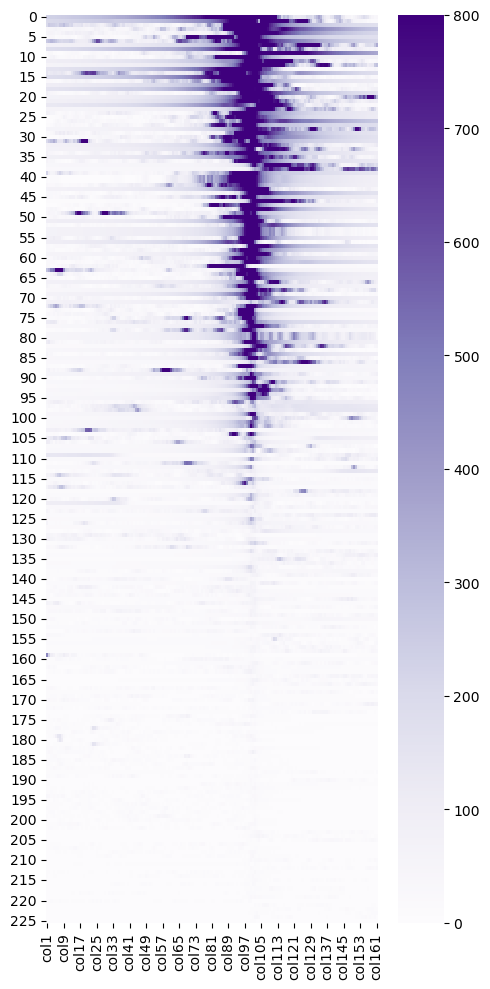

In [36]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [5, 10]
plt.rcParams["figure.autolayout"] = True

# cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
# p1 = sns.heatmap(df.iloc[:, 6:67], vmin=0, vmax=1000, cmap="Purples")
p1 = sns.heatmap(df.iloc[:, 6:167], vmin=0, vmax=800, cmap="Purples")
fig_p1 = p1.get_figure()
# fig_p1.savefig("./H3K4me3_heatmap.pdf", dpi=300)
# fig_p1.savefig("./ATACSeq_TSS_heatmap.pdf", dpi=300)

In [37]:
a = df.iloc[:, 6:67].sum(0) / 161

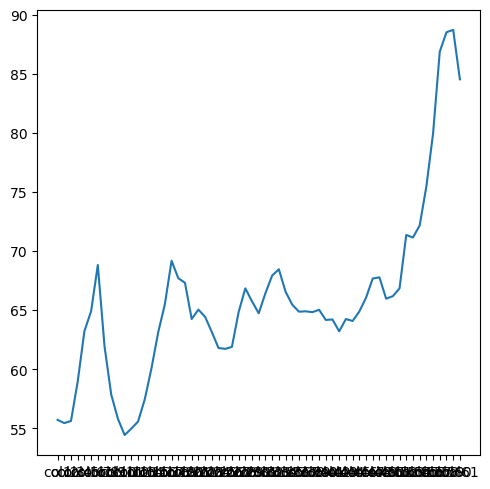

In [38]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.rcParams["figure.autolayout"] = True

p2 = sns.lineplot(a)
fig_p2 = p2.get_figure()
# fig_p2.savefig("./ATACSeq_TSS_profile.pdf", dpi=300)